# Overfitting and Regularization

# Примечание

Из-за проблем с гитом, выводы ячеек не отображаются, советую использовать nbviewer для просмотра работы.

Ссылка на данный ноутбук, открытый в ndviewer:

https://nbviewer.org/github/Sekai-no-uragawa/RS-School/blob/33c7d4222c1e66327c841e27722436c7a181dc33/4_overfitting_regularization/overfitting_regularization.ipynb

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

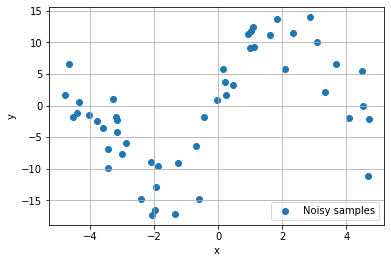

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

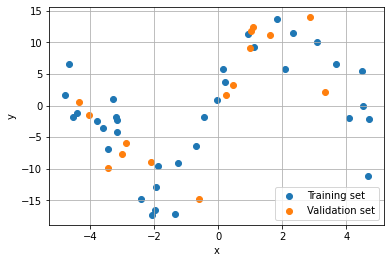

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [8]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [9]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

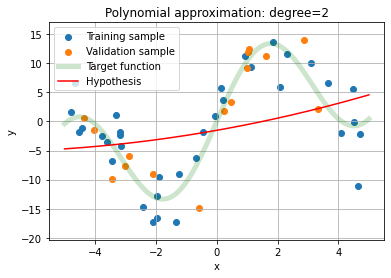

In [10]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

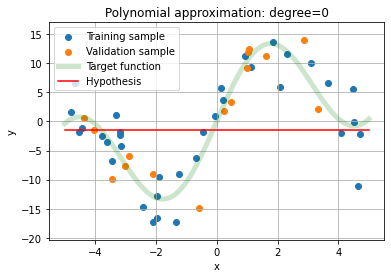

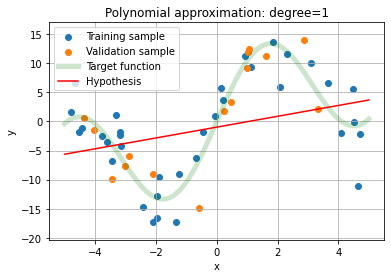

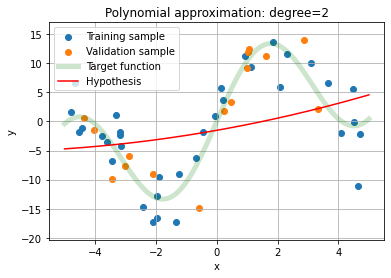

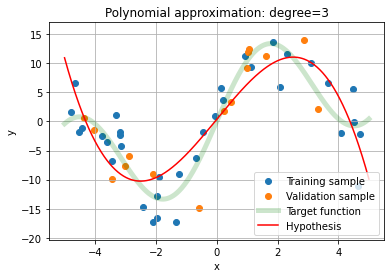

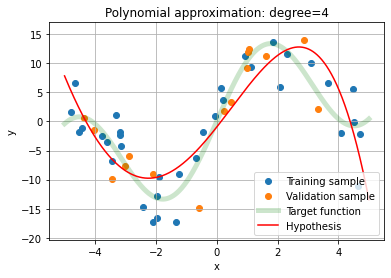

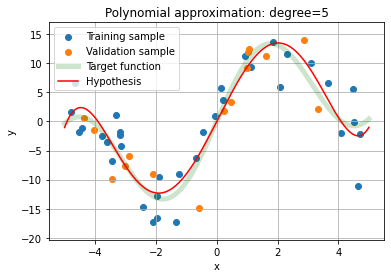

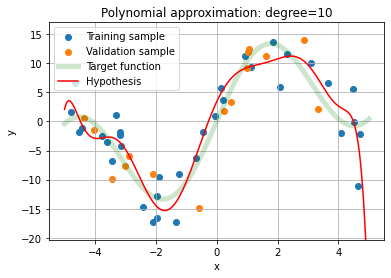

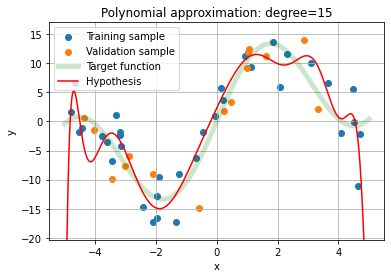

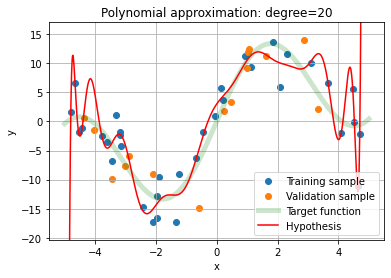

In [11]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

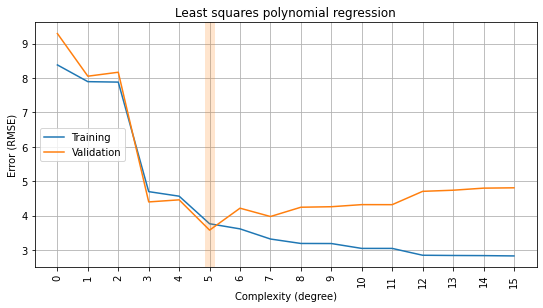

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [13]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

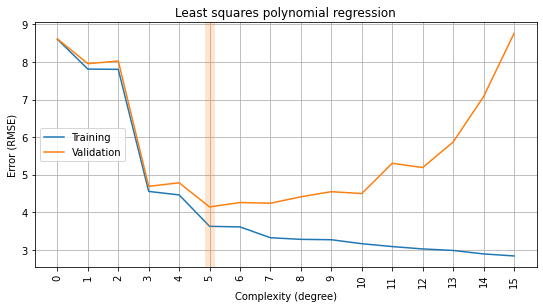

In [16]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [17]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

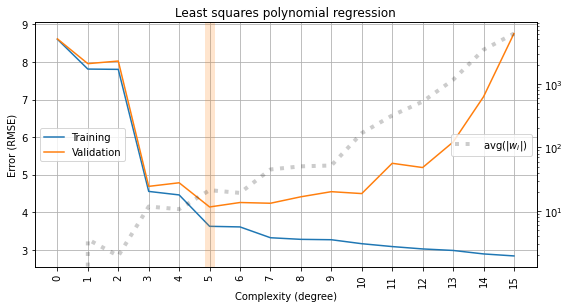

In [18]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

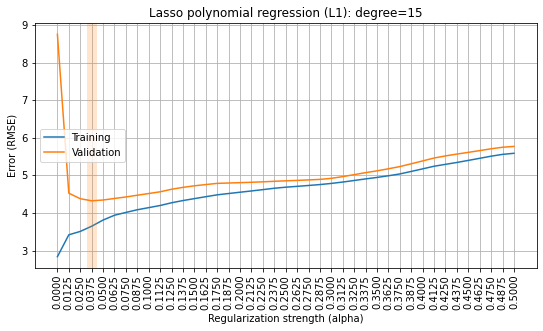

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

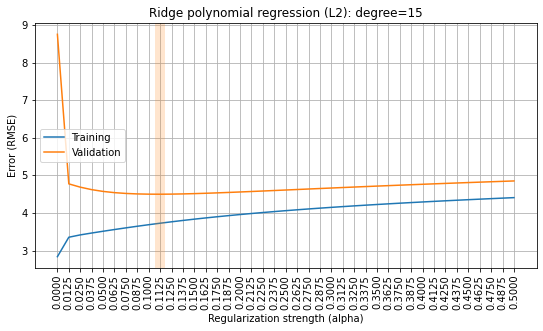

In [20]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [21]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

### Разобьем наш датасет на тест / валид

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

### Сделаем пайплайн, в котором будем полиномизировать только фичи с третьей по пятую (для уменьшения времени вычислений)

In [23]:
def make_model(degree):
    
    return Pipeline([
        ('column_trans', ColumnTransformer(
            [('pol', PolynomialFeatures(degree=degree, include_bias=(degree == 0)), slice(2, 6))],
            remainder='passthrough'
            )
        ), 
        ('sca', StandardScaler()),
        ('lr', LinearRegression())
    ])

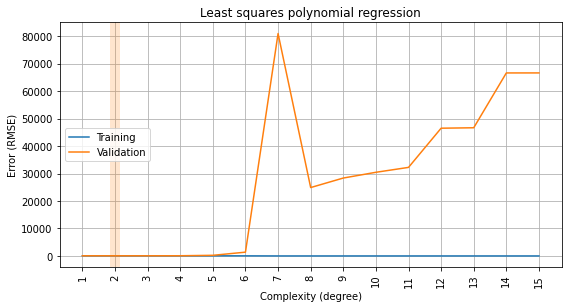

In [24]:
rmse_train, rmse_valid = [], []
for degree in DEGREES[1:]:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

In [25]:
rmse_valid[np.argmin(rmse_valid)]

52.9594806828216

In [26]:
rmse_train[np.argmin(rmse_valid)]

53.039644933682304

In [27]:
rmse_valid

[53.12003915269995,
 52.9594806828216,
 53.16064619597975,
 66.78370584429949,
 224.77534358399137,
 1370.1034434438375,
 80977.83123413108,
 24898.277642556677,
 28363.991386630372,
 30456.592974933563,
 32240.704426660435,
 46508.89003648954,
 46671.37101798808,
 66632.34760330811,
 66641.80869254057]

In [28]:
rmse_train

[54.074408724527814,
 53.039644933682304,
 51.40867370994188,
 48.44507499272151,
 41.797031392777974,
 32.039876381176406,
 4.798400778506945e-09,
 3.0667899611280276e-10,
 3.734058719093859e-10,
 2.508986030253625e-10,
 4.734178091716036e-10,
 2.627993199401021e-10,
 3.191778023021236e-10,
 3.8291242317150916e-10,
 4.5710515004499557e-10]

Наилучшая степень полиномилизации с минимальной ошибкой на тестовой выборке - вторая

При степенях > 4 - явное переобучение - ошибка на валидационных данных резко растет, а на тренировочных - стремительно уменьшается, значит модель потеряла свое обобщающее свойство.

Различия в ошибке между первой и второй степенью полинома не слишком большие, возможно что довольно неплохо данные описываются обычным линейным уравнением, либо фичи для полиномизации были выбраны неверно

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [29]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('column_trans', ColumnTransformer(
            [('pol', PolynomialFeatures(degree=degree, include_bias=(degree == 0)), slice(2, 6))],
            remainder='passthrough'
            )
        ), 
        ('sca', StandardScaler()),
        ('regressor', regressor)
    ])

#### L1

c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+04, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e+03, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e+02, tolerance: 1.900e+02
  model = cd_fast.enet_coo

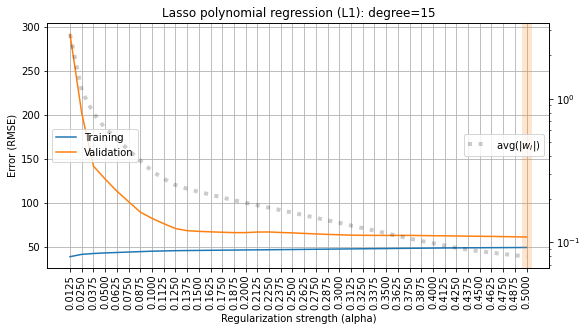

In [30]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:
    reg = make_model(degree=15, alpha=alpha, penalty='L1').fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef.append(                 
            # mean absolute value of weights
            np.mean(np.abs(reg['regressor'].coef_))
            )
    
plot_fitting_graph(ALPHAS[1:], rmse_train[1:], rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef[1:], custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

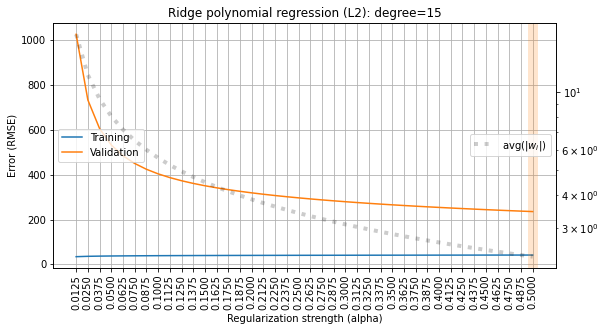

In [31]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:
    reg = make_model(degree=15, alpha=alpha, penalty='L2').fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef.append(                 
            # mean absolute value of weights
            np.mean(np.abs(reg['regressor'].coef_))
            )
    
plot_fitting_graph(ALPHAS[1:], rmse_train[1:], rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef[1:], custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary

Видно, что с увеличением альфы средние значения весов (avg |w|) резко уменьшаются - L1 и L2 вводят все большие штрафы за большие значения весов

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [32]:
def plot_weight_graph(x, weights, xlabel, ylabel, shift=0, regularization = None,
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    
    if regularization == 1:
        for i in range(len(weights[0][0])):
            lst = []
            for num, j in enumerate(weights[shift:]):
                if num == 0:
                    lst.append(j[0][i])
                else:
                    lst.append(j[i])
            plt.plot(x[shift:], lst, label=f'w{i}')
    
    if regularization == 2:
        for i in range(len(weights[0][0])):
            lst = []
            for j in (weights[shift:]):
                lst.append(j[0][i])
            plt.plot(x[shift:], lst, label=f'w{i}')
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    #plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

#### L1

In [33]:
rmse_train, rmse_valid, weights_L1 = [], [], []
for alpha in ALPHAS:
    reg = make_model(degree=15, alpha=alpha, penalty='L1').fit(X_train, y_train)
    weights_L1.append(reg['regressor'].coef_)


c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+04, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e+03, tolerance: 1.900e+02
  model = cd_fast.enet_coordinate_descent(
c:\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e+02, tolerance: 1.900e+02
  model = cd_fast.enet_coo

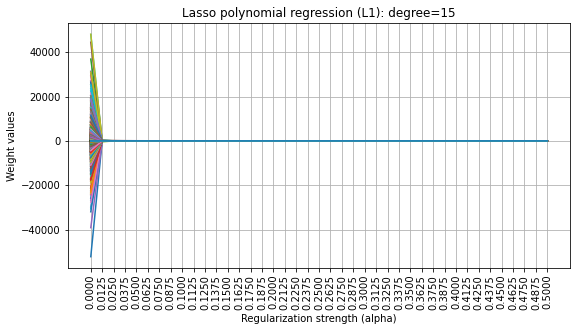

In [34]:
plot_weight_graph(x=ALPHAS, weights=weights_L1, regularization=1,
                   xlabel='Regularization strength (alpha)', ylabel='Weight values',
                   title='Lasso polynomial regression (L1): degree=15')

Видно, что L1 регуляризация значительно уменьшает значения весов

Посчитаем количество нулевых весов

In [35]:
def plot_zero_weights(x, weights, xlabel, ylabel, shift=0, regularization = None,
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    w = weights.copy()
    
    if regularization == 1:
        for i in range(1, len(w)):
            w[i] = [w[i]]
            
    lst = []
    for weight_iter in w:
        count = 0
        for i in weight_iter[0]:
            if i == 0:
                count += 1
        lst.append(count)
    print('Количество нулевых весов при альфа = 0.5:', lst[-1])
    plt.plot(x, lst, label=f'w{i}')            
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    #plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

Всего фичей: 3881
Количество нулевых весов при альфа = 0.5: 3832


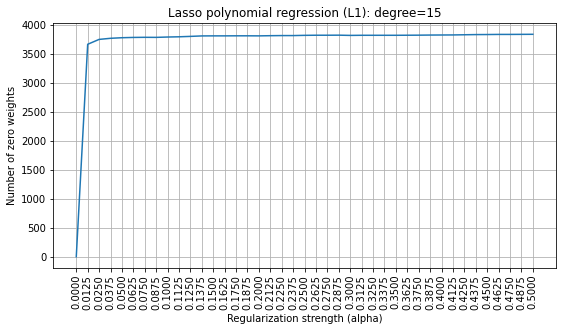

In [36]:
print('Всего фичей:', len(weights_L1[0][0]))
plot_zero_weights(x=ALPHAS, weights=weights_L1, regularization=1,
                   xlabel='Regularization strength (alpha)', ylabel='Number of zero weights',
                   title='Lasso polynomial regression (L1): degree=15')

Как видно, большинство фичей было обнулено

Все дело в производной (градиенте) от функции потерь. У L1 в виде штрафа используется модуль. (Производная доопределяется значением 0 в нуле)

В случае модуля производная является константой с абсолютной величиной, равной +- единице умноженной на альфа. Поэтому при L1-регуляризации градиентный спуск будет стремиться к нулю с постоянной скоростью, а достигнув его, там и останется.

Параметр альфа будет регулировать величину шага, и чем он выше - тем быстрее обнулять менее значимые фичи

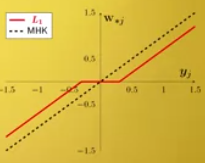

#### L2

In [38]:
rmse_train, rmse_valid, weights_L2 = [], [], []
for alpha in ALPHAS:
    reg = make_model(degree=15, alpha=alpha, penalty='L2').fit(X_train, y_train)
    weights_L2.append(reg['regressor'].coef_)

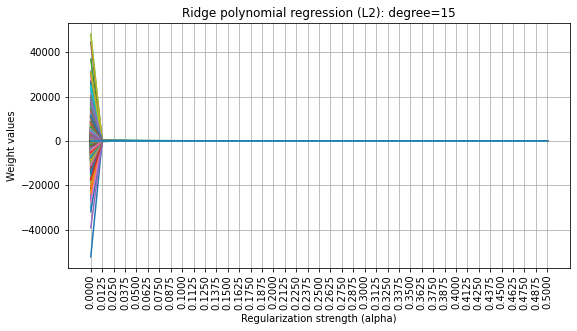

In [39]:
plot_weight_graph(ALPHAS, weights_L2, regularization=2,
                   xlabel='Regularization strength (alpha)', ylabel='Weight values',
                   title='Ridge polynomial regression (L2): degree=15')

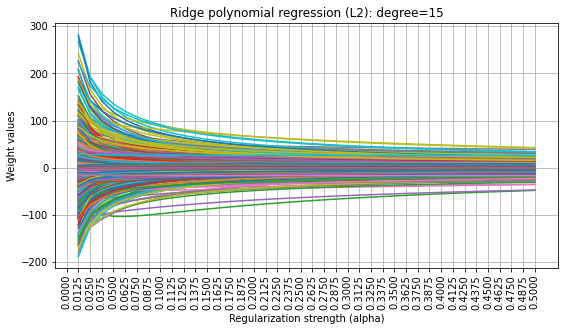

In [40]:
plot_weight_graph(ALPHAS, weights_L2, shift=1, regularization=2,
                   xlabel='Regularization strength (alpha)', ylabel='Weight values', 
                   title='Ridge polynomial regression (L2): degree=15')

Видно, что L2 регуляризация также значительно уменьшает значения весов

Посчитаем количество нулевых весов

Всего фичей: 3881
Количество нулевых весов при альфа = 0.5: 0


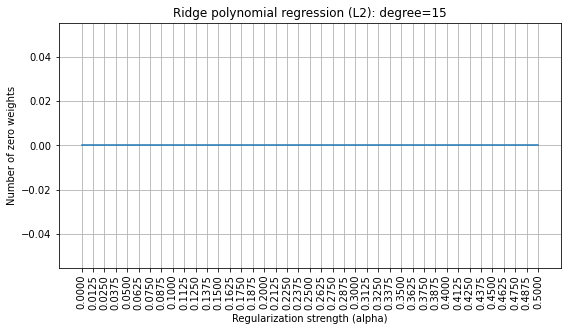

In [41]:
print('Всего фичей:', len(weights_L2[0][0]))
plot_zero_weights(x=ALPHAS, weights=weights_L2, regularization=2,
                   xlabel='Regularization strength (alpha)', ylabel='Number of zero weights',
                   title='Ridge polynomial regression (L2): degree=15')

Видно, что обнуленных весов нет.

Дело опять же в градиенте функции потерь - у L2 доп. член - квадратичный, дифференцируемый на всей области определения, а значит при достаточно маленьких значениях весов он не будет их занулять, а лишь еще немного уменьшать, причем чем они меньше - тем меньше шаг градиентного спуска и меньше уменьшение

#### Summary

**L1** регуляризация позволяет отбирать признаки по их значимости на влияние на модель, обнуляя веса, а **L2** регуляризация способствует малой величине всех весовых коэффициентов

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [57]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


### Создадим две функции для создания пайплайна с *StandardScaler* и без него, а также немного изменим функцию отрисовки количества нулевых весов

In [58]:
def make_model_with_sca(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=500000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=500000) 
    
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('regressor', regressor)
    ])

In [59]:
def make_model_no_sca(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=500000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=500000) 
    
    
    return Pipeline([
        ('regressor', regressor)
    ])

In [60]:
def plot_zero_weights(x, weights, xlabel, ylabel, shift=0, regularization = None,
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    w = weights.copy()
    
    if regularization == 1:
        for i in range(0, len(w)):
            w[i] = [w[i]]
            
    lst = []
    for weight_iter in w:
        count = 0
        for i in weight_iter[0]:
            if i == 0:
                count += 1
        lst.append(count)
    print('Количество нулевых весов при альфа = 0.5:', lst[-1])
    plt.plot(x, lst, label=f'w{i}')            
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    #plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

#### L1

#### Построим графики со значениями ошибок и значениями весов при использовании StandardScaler и без него

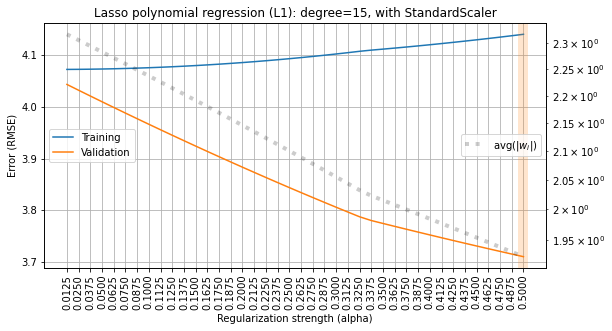

In [62]:
rmse_train, rmse_valid, avg_coef, weights_L1_with_sca = [], [], [], []
for alpha in ALPHAS:
    reg = make_model_with_sca(degree=15, alpha=alpha, penalty='L1').fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef.append(                 
            # mean absolute value of weights
            np.mean(np.abs(reg['regressor'].coef_))
            )
    weights_L1_with_sca.append(reg['regressor'].coef_)
    
plot_fitting_graph(ALPHAS[1:], rmse_train[1:], rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef[1:], custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15, with StandardScaler')

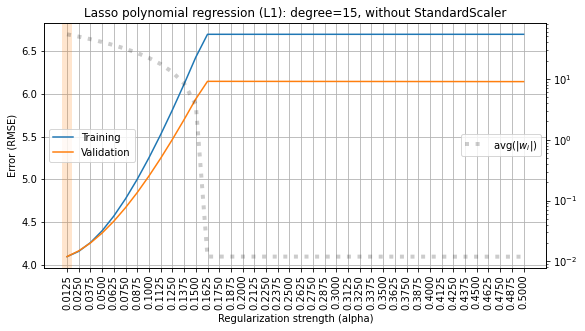

In [63]:
rmse_train, rmse_valid, avg_coef, weights_L1_no_sca = [], [], [], []
for alpha in ALPHAS:
    reg = make_model_no_sca(degree=15, alpha=alpha, penalty='L1').fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef.append(                 
            # mean absolute value of weights
            np.mean(np.abs(reg['regressor'].coef_))
            )
    weights_L1_no_sca.append(reg['regressor'].coef_)
    
plot_fitting_graph(ALPHAS[1:], rmse_train[1:], rmse_valid[1:],
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef[1:], custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15, without StandardScaler')

#### Построим графики с количиством обнуленных весов в зависимости от силы регуляризации

Всего фичей: 3
Количество нулевых весов при альфа = 0.5: 1


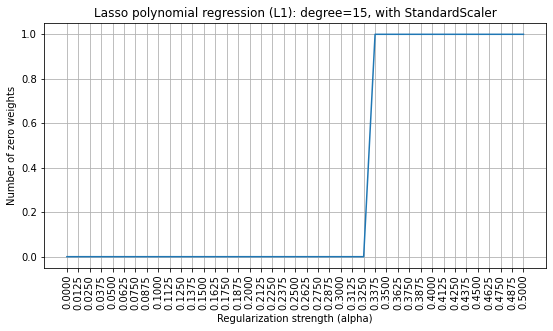

In [64]:
print('Всего фичей:', len(weights_L1_with_sca[0]))
plot_zero_weights(x=ALPHAS, weights=weights_L1_with_sca, regularization=1,
                   xlabel='Regularization strength (alpha)', ylabel='Number of zero weights',
                   title='Lasso polynomial regression (L1): degree=15, with StandardScaler')

Всего фичей: 3
Количество нулевых весов при альфа = 0.5: 1


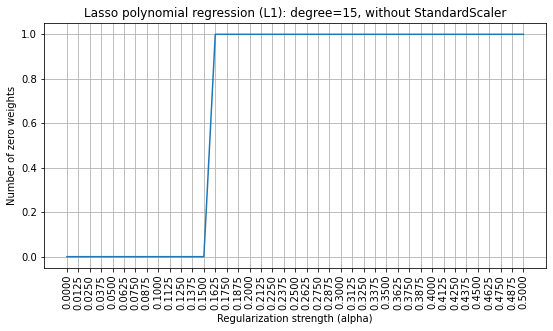

In [65]:
print('Всего фичей:', len(weights_L1_no_sca[0]))
plot_zero_weights(x=ALPHAS, weights=weights_L1_no_sca, regularization=1,
                   xlabel='Regularization strength (alpha)', ylabel='Number of zero weights',
                   title='Lasso polynomial regression (L1): degree=15, without StandardScaler')

#### L2

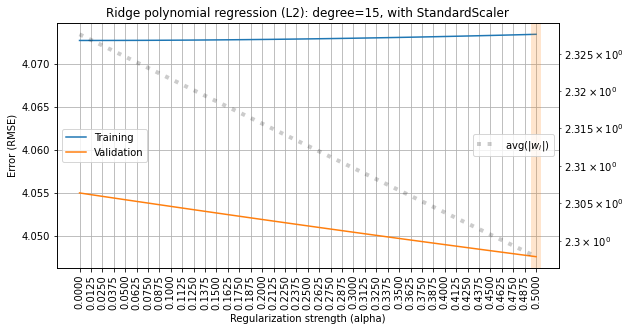

In [66]:
rmse_train, rmse_valid, avg_coef, weights_L2_with_sca = [], [], [], []
for alpha in ALPHAS:
    reg = make_model_with_sca(degree=15, alpha=alpha, penalty='L2').fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef.append(                 
            # mean absolute value of weights
            np.mean(np.abs(reg['regressor'].coef_))
            )
    weights_L2_with_sca.append(reg['regressor'].coef_)
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15, with StandardScaler')

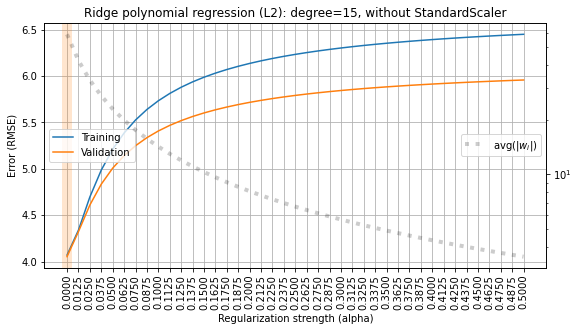

In [67]:
rmse_train, rmse_valid, avg_coef, weights_L2_no_sca = [], [], [], []
for alpha in ALPHAS:
    reg = make_model_no_sca(degree=15, alpha=alpha, penalty='L2').fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef.append(                 
            # mean absolute value of weights
            np.mean(np.abs(reg['regressor'].coef_))
            )
    weights_L2_no_sca.append(reg['regressor'].coef_)
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15, without StandardScaler')

#### Строить графики с количиством обнуленных весов в зависимости от силы регуляризации для L2 нет смысла, т.к. выше мы уже показали, что L2 не обнуляет веса, а лишь сильно может приближаться к нулю

#### Summary



По итогу мы видим, что пренебрежение использованием StandardScaler-ом приводит к ухудшению результатов: из-за разных масштабов значений признаков веса также будут масштабированы поразному, что, в случае **L1**, приводит к неправильной оценке значимости признаков и неверному их обнулению, т.к. признаки разного масштаба, а штрафы вводятся линейные, то и обнлится признак, наиболее близкий к нулю, но не факт, что он был ненужен. И на графике ошибки видно, что применение L1 без нормализации приводит лишь к увеличению ошибок на тестовой и тренировочной выборках.

Для **L2** аналогичная ситуация, только из-за разных масштабов признаков вводится больший штраф в б**о**льшие по модулю признаки, что скорее всего может оказаться неверным и привести к уменьшению их влияния на модель, а следовательно и к неправильным результатам. На графике ошибок видно, что наилучшая точность достигалась на нулевом шаге, до применения регуляризации без нормализации.